# <b> Grouping Topics with Kmeans and TFIDF

### Setup

In [1]:
import warnings
warnings.filterwarnings("ignore")

import pandas as pd

from src import Cleaning, Visualization
import matplotlib.pyplot as plt

from sklearn.metrics.pairwise import cosine_similarity
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import KMeans
from sklearn.decomposition import TruncatedSVD
from sklearn.manifold import TSNE

### Data Loading

In [2]:
papers_df = pd.read_csv('../datasets/papers.csv')
papers_df = papers_df[['TITLE', 'ABSTRACT']]

In [12]:
papers_df.sample(5)

,TITLE,ABSTRACT
20854,Beyond Sparsity: Tree Regularization of Deep M...,The lack of interpretability remains a key b...
5759,On radial Schroedinger operators with a Coulom...,This paper presents a thorough analysis of 1...
18536,Convex and non-convex regularization methods f...,This paper deals with feature selection proc...
18830,Consistency Results for Stationary Autoregress...,We consider stationary autoregressive proces...
17934,The Meaning of Memory Safety,We give a rigorous characterization of what ...


### Data Processing

In [15]:
clean_text = Cleaning.DataCleaning()
papers_df.loc[:, 'clean_title'] = papers_df['TITLE'].apply(lambda x: " ".join(clean_text(x)))
papers_df.loc[:, 'clean_text'] = papers_df['ABSTRACT'].apply(lambda x: " ".join(clean_text(x)))

In [17]:
papers_df.loc[:, 'word_count'] = papers_df['clean_text'].apply(lambda x: len(x.split()))

### Data Visualization

In [18]:
data_viz = Visualization.Visualization(papers_df, 'clean_text')
frequency = data_viz.words_frequency()

In [19]:
frequency.head(10)

,words,freq,norm
1,model,15679,0.008960
42,method,10834,0.006192
9,data,10304,0.005889
88,result,9476,0.005415
131,network,9249,0.005286
189,system,8799,0.005029
72,problem,8780,0.005018
99,show,8644,0.004940
65,algorithm,7879,0.004503
59,using,7394,0.004226


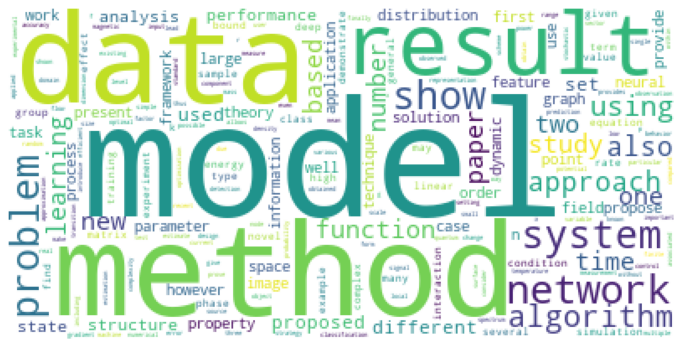

In [20]:
data_viz.word_cloud()

## Clustering 

### TFIDF and Kmeans

In [21]:
sentences = papers_df['clean_text']

In [22]:
#define vectorizer parameters
tfidf_vectorizer = TfidfVectorizer(ngram_range=(1, 10),
                                    max_df=0.8,
                                    min_df=0.2,
                                    max_features=1000,
                                    norm='l1')

# words by their importance 
tfidf_matrix = tfidf_vectorizer.fit_transform(sentences) #fit the vectorizer to synopses
idf_df = pd.DataFrame(tfidf_matrix.toarray(), columns=tfidf_vectorizer.get_feature_names())

terms = tfidf_vectorizer.get_feature_names()

In [23]:
#The best cluster in range of 2 to 6
cluster_range = range(2,6) 
#model fit using TF-IDf
km_modelfit= [KMeans(n_clusters=k).fit(tfidf_matrix) for k in cluster_range]
#Centroids for K means algorithm
centroids = [k.cluster_centers_ for k in km_modelfit]

In [24]:
distortions = []
K = range(1,6)
for k in K:
    kmeanModel = KMeans(n_clusters=k, init='k-means++', n_init=20, precompute_distances='auto')
    kmeanModel.fit(tfidf_matrix)
    distortions.append(kmeanModel.inertia_)

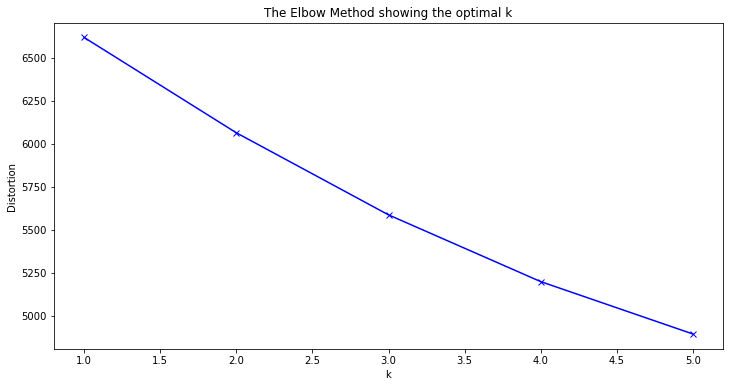

In [25]:
plt.figure(figsize=(12,6))
plt.plot(K, distortions, 'bx-')
plt.xlabel('k')
plt.ylabel('Distortion')
plt.title('The Elbow Method showing the optimal k')
plt.show()

This test helps us to choose the number of clusters needed

### Train KMeans with the best Cluster size 

In [26]:
dist = 1 - cosine_similarity(tfidf_matrix)

best_K = 4
model = KMeans(best_K, init='k-means++', n_init=20, precompute_distances='auto')  
model.fit(tfidf_matrix)  #fit kmeans for k=3
clusters = model.labels_.tolist()

common_words = model.cluster_centers_.argsort()[:,-1:-11:-1]
for num, centroid in enumerate(common_words):
    print(str(num) + ' : ' + ', '.join(terms[word] for word in centroid))

0 : system, model, result, show, study, using, paper, two, also, based
1 : result, show, study, also, paper, two, using, problem, based, model
2 : model, data, show, using, result, study, two, paper, method, also
3 : method, problem, data, paper, using, approach, also, two, based, study


In [67]:
# generates clusters labels
clusters = model.labels_.tolist()
eventos_names = {'TITLE': papers_df.TITLE, 'ABSTRACT': papers_df.ABSTRACT, 'clean_text': papers_df.clean_text, 'TOPIC': clusters, }
group_data = pd.DataFrame.from_dict(eventos_names)
print("Cluster Total Documents")

Cluster Total Documents


### TSNE to view the documents distribution

In [ ]:
X_reduced = TruncatedSVD(n_components=12, random_state=0).fit_transform(tfidf_matrix)
X_embedded = TSNE(n_components=2, perplexity=25, verbose=0).fit_transform(X_reduced)

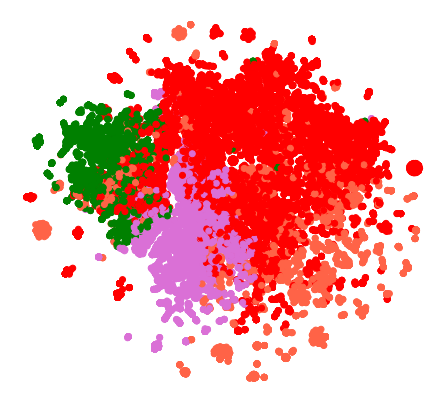

In [60]:
names = ['class_1', 'class_2', 'class_3', 'class_4']

fig = plt.figure(figsize=(6, 6))
ax = plt.axes(frameon=False)
plt.setp(ax, xticks=(), yticks=())
plt.subplots_adjust(left=0.0, bottom=0.0, right=1.0, top=0.9,wspace=0.0, hspace=0.0)
LABEL_COLOR_MAP = {0 : 'green', 1 : 'tomato', 2: 'orchid', 3:'red'}
label_color = [LABEL_COLOR_MAP[l] for l in clusters]
ax = plt.scatter(X_embedded[:, 0], X_embedded[:, 1], marker="o", c = label_color)

### WordCloud for each Cluster group

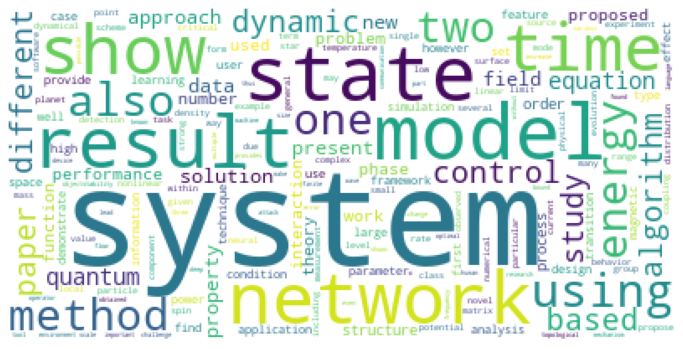

In [68]:
data_viz = Visualization.Visualization(group_data[group_data['TOPIC'] == 0], 'clean_text')
data_viz.word_cloud()

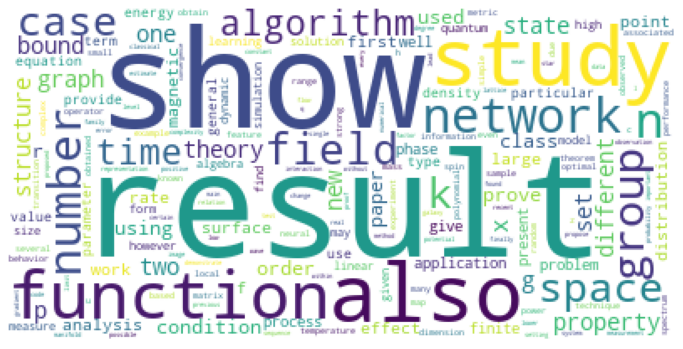

In [69]:
data_viz = Visualization.Visualization(group_data[group_data['TOPIC'] == 1], 'clean_text')
data_viz.word_cloud()

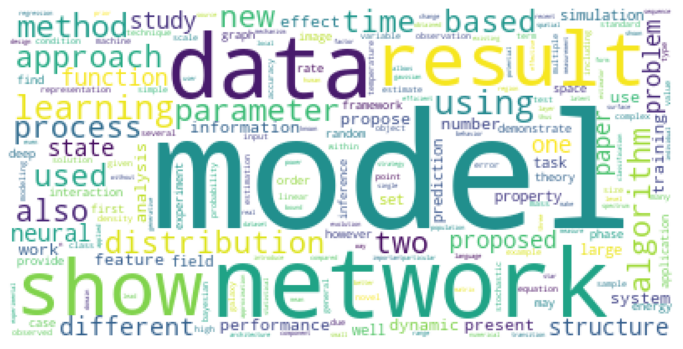

In [70]:
data_viz = Visualization.Visualization(group_data[group_data['TOPIC'] == 2], 'clean_text')
data_viz.word_cloud()

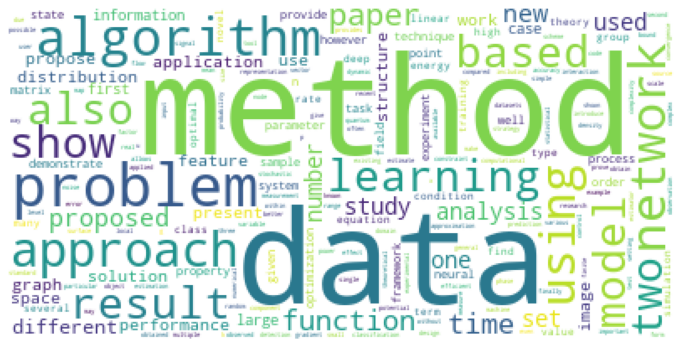

In [71]:
data_viz = Visualization.Visualization(group_data[group_data['TOPIC'] == 3], 'clean_text')
data_viz.word_cloud()